Finetune a Pretrained Hugginface model

In [1]:
!pip install transformers
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.9 MB/s eta 0:00:00


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.5 MB/s eta 0:00:00


In [3]:
!pip install accelerate -U
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=cc15a8d08cdea64ba1eb9869908aff76312a4ea2ac3d54667dd504b092562ecd
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji


In [4]:
#Import Libraries
import os

#Data manipulation
import pandas as pd
import numpy as np
import datasets
from sklearn.model_selection import train_test_split
import collections
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import seaborn as sns

#finetuning
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

#Evaluation
from datasets import load_metric, load_dataset
from sklearn.metrics import f1_score
from huggingface_hub import notebook_login

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#login to huggingface
notebook_login()

Activate weight and Biases

In [7]:
os.environ["WANDB_DISABLED"] = "false"

Load The Datasets

In [8]:
#load data
train_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Career_Accelerator_P5-NLP/zindi_challenge/data/filtered_train.csv')

#check first 5

train_df


,Unnamed: 0,tweet_id,safe_text,label,agreement
0,0,CL1KWCMY,me amp the big homie meanboy meanboy mb mbs mm...,0.0,1.000000
1,1,E3303EME,im thinking of devoting my career to proving a...,1.0,1.000000
2,2,M4IVFSMS,whatcausesautism vaccines do not vaccinate you...,-1.0,1.000000
3,3,1DR6ROZ4,i mean if they immunize my kid with something ...,-1.0,1.000000
4,4,J77ENIIE,thanks to catch me performing at la nuit nycs...,0.0,1.000000
...,...,...,...,...,...
9994,9996,IU0TIJDI,living in a time where the sperm i used to was...,1.0,1.000000
9995,9997,WKKPCJY6,in spite of all measles outbreaks judge in ...,1.0,0.666667
9996,9998,ST3A265H,interesting trends in child immunization in ok...,0.0,1.000000
9997,9999,6Z27IJGD,cdc says measles are at highest levels in deca...,0.0,1.000000


In [9]:
#view info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9999 non-null   int64  
 1   tweet_id    9999 non-null   object 
 2   safe_text   9999 non-null   object 
 3   label       9999 non-null   float64
 4   agreement   9999 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.7+ KB


# Remove the rows with null values in the label and agreement columns of the train_df DataFrame

In [10]:
# Remove rows with null values
train_df.dropna(subset=['label', 'agreement'], inplace=True)

In [11]:
# View info once again
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9999 non-null   int64  
 1   tweet_id    9999 non-null   object 
 2   safe_text   9999 non-null   object 
 3   label       9999 non-null   float64
 4   agreement   9999 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.7+ KB


## tweet_id is an object, the tweet is an object as expected while label and agreements are floats

In [12]:
#look at some of the tweets and how they are written
for tweet in range(10):
    tweet_str=train_df['safe_text'][tweet]
    print(f'{tweet_str}\n')

me amp the big homie meanboy meanboy mb mbs mmr stegmanlife  stegman st 

im thinking of devoting my career to proving autism isnt caused by vaccines due to the idiotic posts ive seen about world autism day

whatcausesautism vaccines do not vaccinate your child

i mean if they immunize my kid with something that wont secretly kill him years down the line then im all for it but i dont trust that

thanks to  catch me performing at la nuit nycst ave show starts at  jennifair mmr… 

 a nearly  year old study when mental health studies and vaccines were relatively in their infancies that has been refuted

study of more than  kids finds no link between mmr vaccine and autism 

psa vaccinate your fucking kids

coughing extra on the shuttle and everyone thinks i have the measles 😂 vaccinateyourkids

aids vaccine created at oregon health amp science university may clear virus from body   



### Findings
Some tweets contain hashtags, others contain numbers while others contain plain text

usernames have been replaced with < user > while links have been replaced with < url >

## Exploratory Data analysis
1. Use wordcloud to look at the most words appearing
2. Check for emojis
3. Most used words

## Visualize frequent words using wordcloud

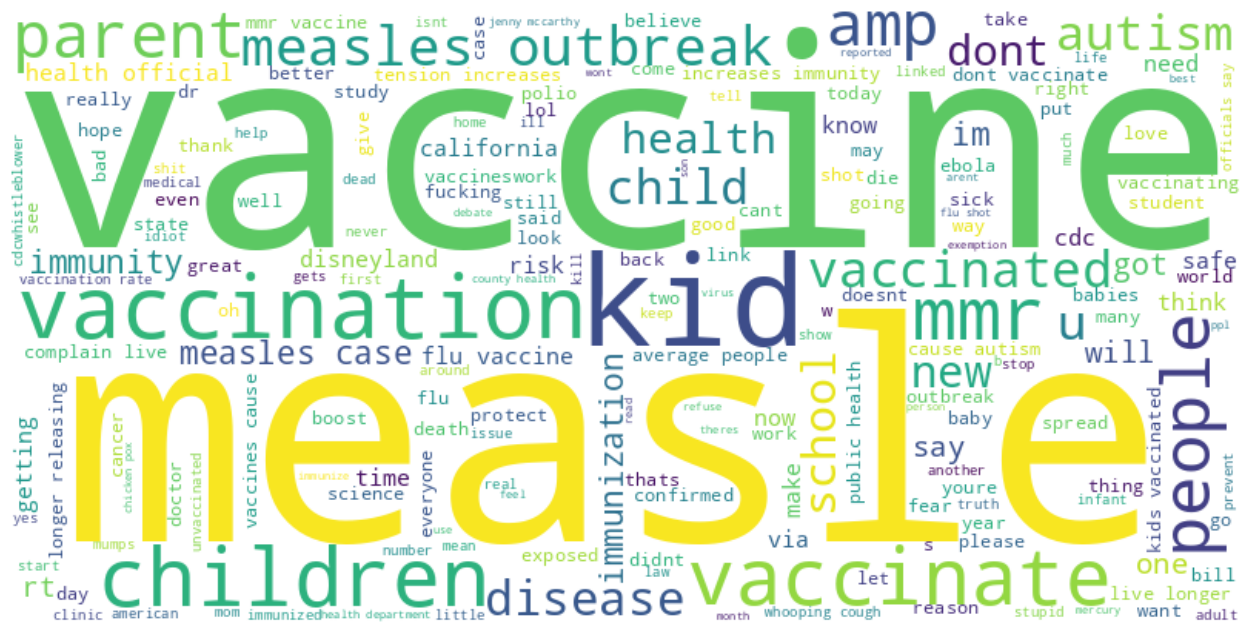

In [13]:
# Generate a word cloud from the message text data
text = " ".join(tweet for tweet in train_df.safe_text)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

# Display the word cloud image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### User and Url won't be relevant to our analysis so lets remove them

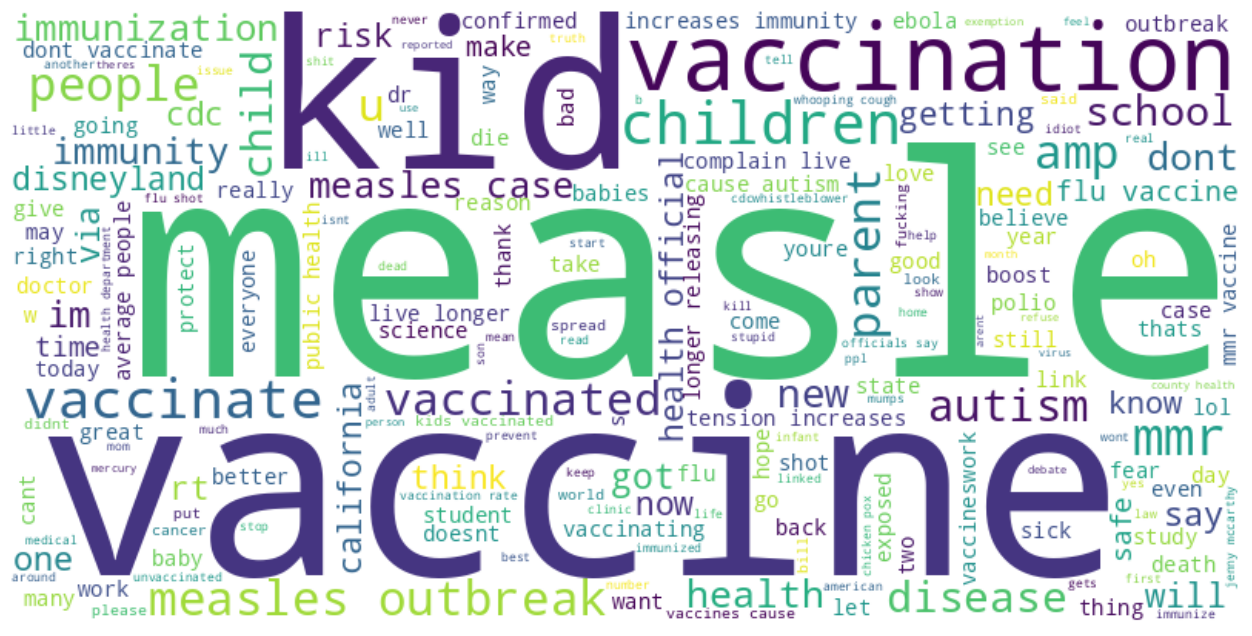

In [14]:
#replace user,url in the df
train_df['safe_text']=train_df['safe_text'].replace({'user':'','url':''},regex=True)


# regenerate wordcloud
text = " ".join(tweet for tweet in train_df.safe_text)
wordcloud = WordCloud(width=800, height=400, max_font_size=200, background_color="white").generate_from_text(text)

# Display the word cloud image
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looks like the the vaccination is for measles and parents might be worried about their kids. This is why we should understand the sentiment in each tweet on how parents feel about this vaccination.

## Let's check word Frequency again using barcharts

In [15]:
# Combine all tweets
tweets = " ".join(train_df['safe_text'].astype(str))

# Split the string into a list of words ignoring special characters
words = re.findall(r'\b\w+\b', tweets)

# Convert all words to lowercase
words = [word.lower() for word in words]

# Count the occurrences of each word using Counter
word_counts = collections.Counter(words)

# Combine words that differ only with 's' at the end
combined_words = []
for word in words:
    if word.endswith('s') and len(word) > 1:
        singular_word = word[:-1]
        if singular_word in word_counts:
            combined_words.append(singular_word)
        else:
            combined_words.append(word)
    else:
        combined_words.append(word)

# Recount the occurrences of each word using Counter
word_counts = collections.Counter(combined_words)

# Get the top 20 most common words and their counts
top_words = dict(word_counts.most_common(20))

top_words

{'the': 4112,
 'to': 3633,
 'measle': 3525,
 'i': 3332,
 'vaccine': 2859,
 'a': 2851,
 'of': 2352,
 'in': 2175,
 'and': 1992,
 'for': 1605,
 'kid': 1455,
 'you': 1207,
 'it': 1205,
 'health': 1145,
 'that': 1099,
 'your': 1077,
 'vaccination': 1018,
 'not': 1010,
 'are': 1004,
 'mmr': 994}

## Visualize word frequency using bar chart

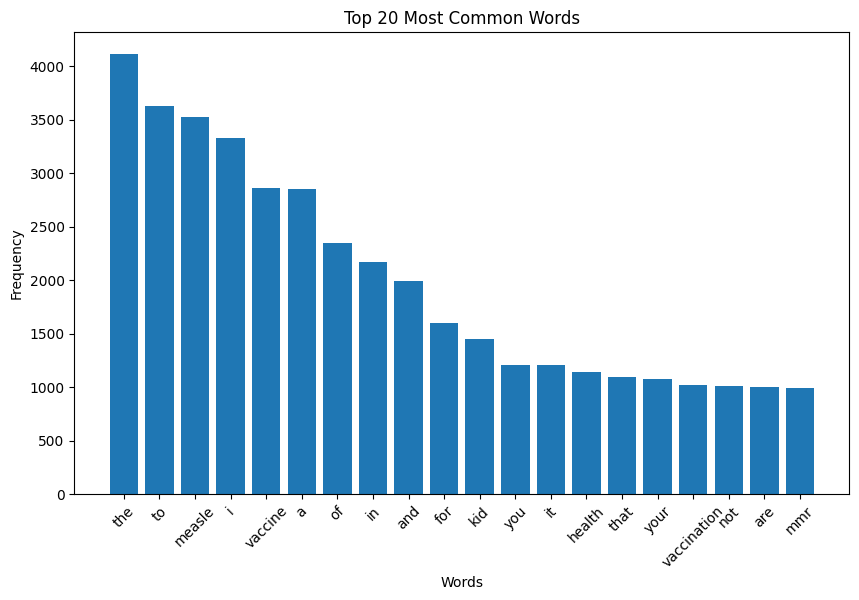

In [16]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()

## Check for the presence of Emojis: Emojis are a fundamental part of tweeting today

In [17]:
#Function to extract all emojis from a text
def extract_emojis(tweet):
    return ''.join(E for E in tweet if E in emoji.EMOJI_DATA)


# Extract all emojis from the message text data
emojis = extract_emojis(tweets)

- As expected we do have some emojis in our text
- We can decide to fine tune algorithms that can handle emojis

In [18]:
# Create a list of all the extracted emojis
emojis_list = list(emojis)

# Count the frequency of each emoji in the list
emoji_dict = dict(collections.Counter(emojis_list))

# Sort the dictionary in descending order of frequency
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

# Convert the dictionary to a pandas DataFrame
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

# Display the top 20 most frequently used emojis
print(emoji_df.head(10))

  emoji  count
0     😂    140
1     💉     63
2     😷     58
3     🔥     52
4     😳     39
5     😭     39
6     💥     30
7     😒     29
8     🙌     27
9     👏     25


- The most frequently used emoji is 😂 with a count of 140. This emoji is commonly associated with laughter or amusement.

- The second most frequently used emoji is 💉 with a count of 63. This emoji represents a syringe and is often used in the context of healthcare, vaccinations, or medical topics.

- The third most frequently used emoji is 😷 with a count of 58. This emoji depicts a face wearing a medical mask and is commonly used to represent sickness, health precautions, or protection.

## Visualize the top 10 most use

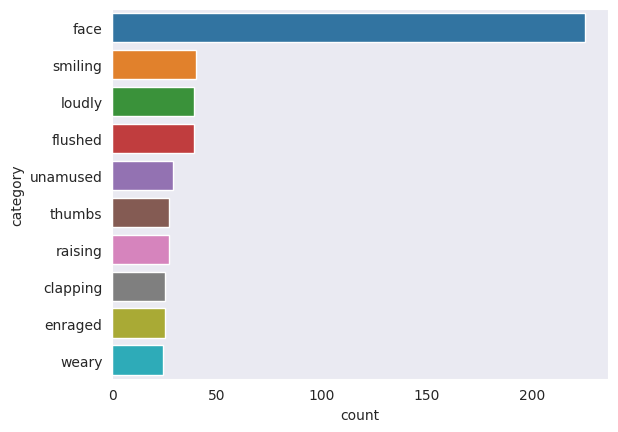

In [19]:
# Group the emojis by category
emoji_dict = collections.defaultdict(int)
for emoji_char in emojis_list:
    emoji_desc = emoji.demojize(emoji_char, delimiters=("", ""))
    emoji_desc_parts = emoji_desc.split("_")
    if len(emoji_desc_parts) > 1:
        emoji_category = emoji_desc_parts[0]
        emoji_dict[emoji_category] += 1

# Convert the dictionary to a pandas DataFrame
emoji_df = pd.DataFrame(emoji_dict.items(), columns=['category', 'count'])

# Sort the DataFrame by frequency count in descending order
emoji_df = emoji_df.sort_values(by='count', ascending=False)

# Select the top 10 rows
top_10_emojis = emoji_df.head(10)
sns.set_style('dark')
sns.barplot(x='count',y='category',data=emoji_df.head(10));

## Distribution of Sentiment Labels

In [20]:
# Calculate the frequency of each sentiment label
label_counts = train_df['label'].value_counts()
label_counts

 0.0    4908
 1.0    4053
-1.0    1038
Name: label, dtype: int64

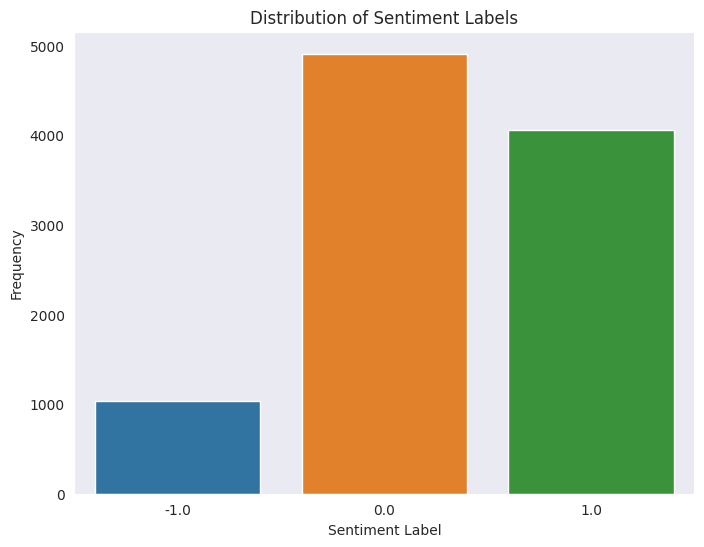

In [21]:
train_df['label'] = train_df['label'].astype('category')
# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=train_df['label'].value_counts().index, y=train_df['label'].value_counts().values)
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.show()

**The labels are not perfectly balanced, as there is some variation in the frequencies. However, the difference between the frequencies of the labels is not extremely large, which suggests a relatively balanced distribution.**

## To perform text length analysis on the "safe_text" column

In [22]:
# Calculate the length of each text in the "safe_text" column
text_lengths = train_df['safe_text'].apply(len)

# Compute descriptive statistics of text lengths
text_length_stats = text_lengths.describe()

# Print the descriptive statistics
print(text_length_stats)

count    9999.000000
mean       89.818982
std        29.266984
min         3.000000
25%        69.000000
50%        95.000000
75%       112.000000
max       142.000000
Name: safe_text, dtype: float64


## Visualize the distribution of text lengths using histograms or box plots.

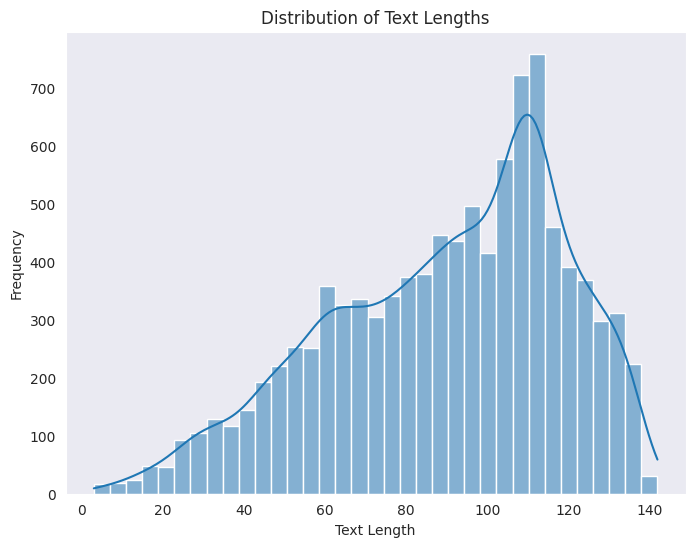

In [23]:
# Create a histogram to visualize the distribution of text lengths
plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, kde=True)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

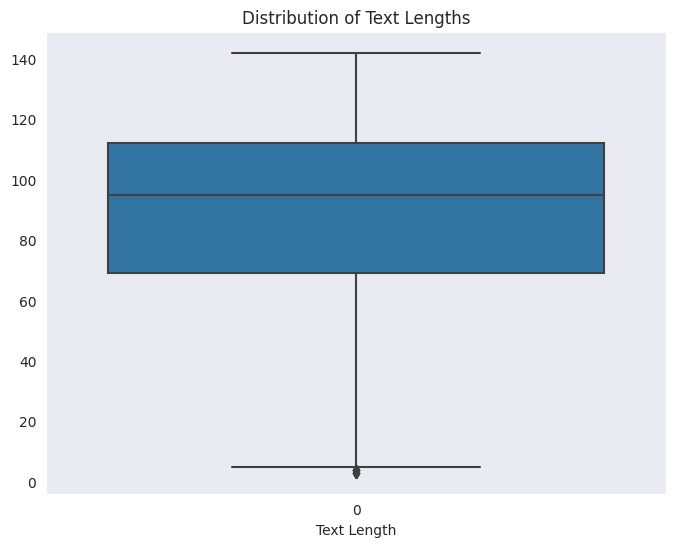

In [24]:
# Create a box plot to visualize the distribution of text lengths
plt.figure(figsize=(8, 6))
sns.boxplot(text_lengths)
plt.xlabel('Text Length')
plt.title('Distribution of Text Lengths')
plt.show()

## Perform agreement analysis on the data

In [25]:
# Calculate descriptive statistics for the "agreement" column
agreement_mean = train_df['agreement'].mean()
agreement_median = train_df['agreement'].median()
agreement_std = train_df['agreement'].std()

# Print the results
print("Agreement Mean:", agreement_mean)
print("Agreement Median:", agreement_median)
print("Agreement Standard Deviation:", agreement_std)

Agreement Mean: 0.8542520918758542
Agreement Median: 1.0
Agreement Standard Deviation: 0.18070719805774949


## Visualize the distribution of the "agreement" values using a histogram:

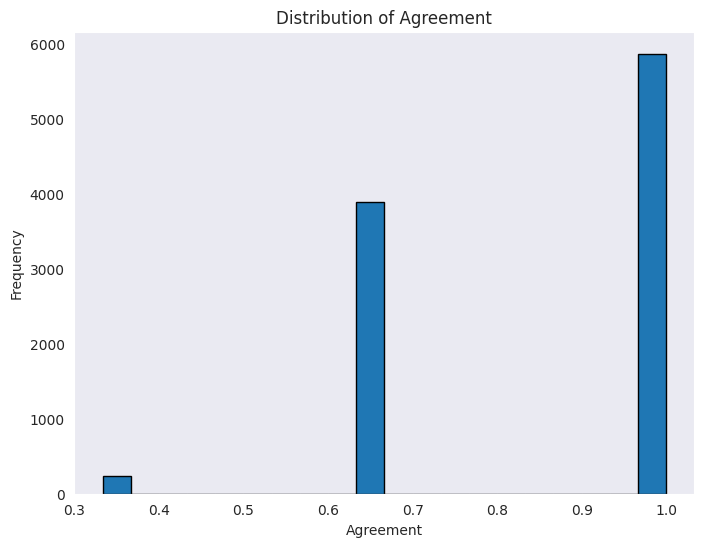

In [26]:
# Plot a histogram
plt.figure(figsize=(8, 6))
plt.hist(train_df['agreement'], bins=20, edgecolor='black')
plt.xlabel('Agreement')
plt.ylabel('Frequency')
plt.title('Distribution of Agreement')
plt.show()

## Visualize the distribution of the "agreement" values using  a box plot:

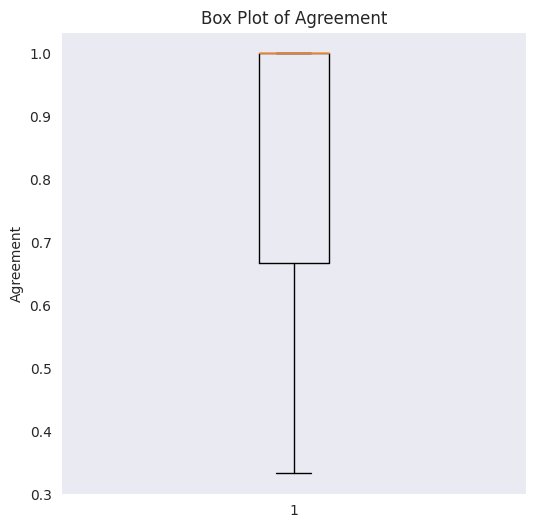

In [27]:
# Plot a box plot
plt.figure(figsize=(6, 6))
plt.boxplot(train_df['agreement'])
plt.ylabel('Agreement')
plt.title('Box Plot of Agreement')
plt.show()

Overall, the high mean and median agreement values, along with the low standard deviation, suggest a generally high level of consensus among annotators in the sentiment annotations. This is a positive indication for the reliability and consistency of the sentiment labels in the dataset.

## Counting the sentiment labels within each agreement level category

In [28]:
# Counting the sentiment labels within each agreement level category
label_counts = train_df.groupby('agreement')['label'].value_counts()

# Printing the label counts for each agreement level category
for agreement, counts in label_counts.groupby(level=0):
    print(f"Agreement Level: {agreement}")
    print(counts)
    print('\n')

Agreement Level: 0.3333333333333333
agreement  label
0.333333   -1.0     239
           0.0        0
           1.0        0
Name: label, dtype: int64


Agreement Level: 0.6666666666666666
agreement  label
0.666667   0.0      1748
           1.0      1729
           -1.0      417
Name: label, dtype: int64


Agreement Level: 1.0
agreement  label
1.0        0.0      3160
           1.0      2324
           -1.0      382
Name: label, dtype: int64




These results show the count of sentiment labels within each agreement level category. It appears that the majority of tweets with an agreement level of 0.6666666666666666 have both neutral and positive sentiment labels, while the agreement level of 1.0 has a higher count of neutral sentiment labels compared to negative and positive sentiments. On the other hand, the agreement level of 0.3333333333333333 primarily consists of negative sentiment labels.

## Visualize the distribution of sentiment labels based on the agreement level among annotators

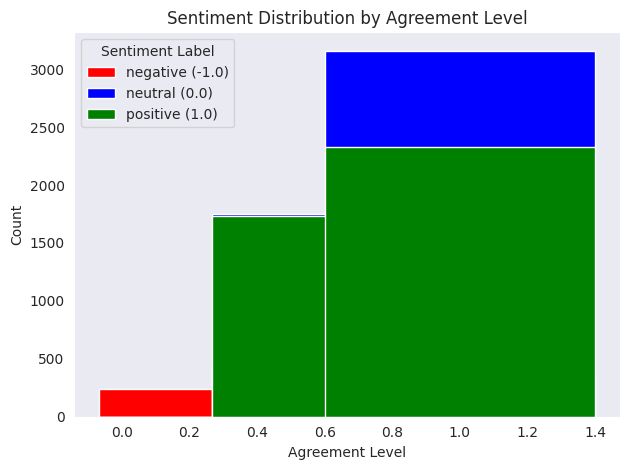

In [29]:
# Counting the sentiment labels within each agreement level category
label_counts = train_df.groupby(['agreement', 'label']).size().unstack()

# Plotting the distribution
fig, ax = plt.subplots()
agreement_levels = label_counts.index
labels = label_counts.columns
colors = ['red', 'blue', 'green']
sentiment_labels = ['negative', 'neutral', 'positive']

for i, sentiment_label in enumerate(labels):
    counts = label_counts[sentiment_label].fillna(0)
    ax.bar(agreement_levels, counts, label=f'{sentiment_labels[i]} ({sentiment_label})', color=colors[i])

ax.set_xlabel('Agreement Level')
ax.set_ylabel('Count')
ax.legend(title='Sentiment Label')

plt.title('Sentiment Distribution by Agreement Level')
plt.tight_layout()
plt.show()

The plot shows the aggregates of the sentiment labels based on the agreement level using the groupby function and showing the distribution. Each sentiment label is represented by a different color, and the legend indicates the corresponding sentiment label.

##  Analyze the association between the sentiment labels and multiple keywords "measle", "measles", "vaccine", "vaccines", "vaccination", and "health"

The code below adds two new columns, 'measles_combined' and 'vaccines_combined', to the train_df DataFrame, which contain the combined occurrences of 'measle' and 'measles', and 'vaccine' and 'vaccines', respectively. The keywords_updated list is also updated to include these combined columns. The keyword_frequencies DataFrame is then calculated based on the updated keywords.

In [30]:
# Create keyword columns
keywords = ['measle', 'measles', 'vaccine', 'vaccines', 'vaccination', 'health']
for keyword in keywords:
    train_df[keyword] = train_df['safe_text'].str.contains(keyword, case=False).astype(int)

# Combine occurrences of 'measle' and 'measles'
train_df['measles_combined'] = train_df['measle'] + train_df['measles']

# Combine occurrences of 'vaccine' and 'vaccines'
train_df['vaccines_combined'] = train_df['vaccine'] + train_df['vaccines']

# Update the keyword list
keywords_updated = ['measles_combined', 'vaccines_combined', 'vaccination', 'health']

# Group the data by sentiment label and calculate keyword frequencies
keyword_frequencies = train_df.groupby('label')[keywords_updated].sum()

# Print the keyword frequencies
keyword_frequencies

,measles_combined,vaccines_combined,vaccination,health
label,,,,
-1.0,210,969,145,70
0.0,4585,1104,298,705
1.0,1875,2408,606,431


## Keyword Frequencies by Sentiment Label

The chart allows us to compare the distribution and relative frequencies of keywords across different sentiment categories.

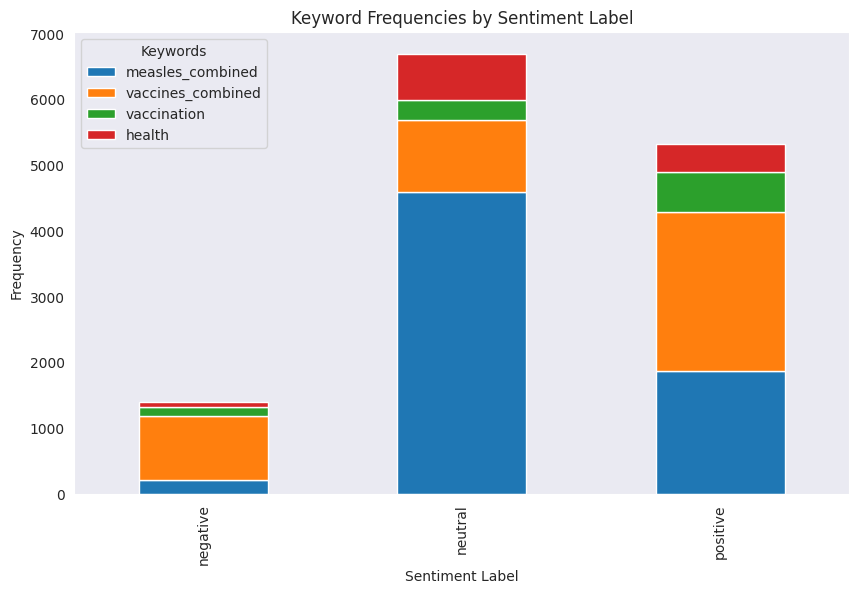

In [31]:
# Set the labels for the sentiment labels
sentiment_labels = ['negative', 'neutral', 'positive']

# Plot the stacked bar chart
keyword_frequencies.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the labels and title
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Keyword Frequencies by Sentiment Label')

# Show the legend
plt.legend(title='Keywords')

# Set the x-axis tick labels as the sentiment labels
plt.xticks(range(len(sentiment_labels)), sentiment_labels)

# Show the plot
plt.show()

From the plot, we cann summarize that:
- The words "measle(s)" are used most (over 4500 times) in the **neutral** sentiment label followed 2nd by "vaccine(s)" and 3rd by word "health".
- The words "vaccine(s)" are used most (about 2000 times) in the **positive** sentiment label followed 2nd by "measle(s)" and 3rd by word "vacciation".
- The words "vaccine(s)" are used most (about 1000 times) in the **negative** sentiment label followed 2nd by "measle(s)" and 3rd by word "vacciation".

## Revert to original Dataset

In [32]:
train_df.drop(train_df.columns.difference(['tweet_id', 'safe_text', 'label', 'agreement']), axis=1, inplace=True)

AS Noticed in EDA we will drop the rows with missing values

In [33]:
#Drop null rows
train_df.dropna(axis=0,inplace=True)

#check for the presence of null values again
train_df.isna().sum()


tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

Split the Train the dataset into training(for learning ) and evaluation(For computing metrics to capture overfitting) sets

In [34]:
train , eval = train_test_split(train_df,train_size=0.8,stratify=train_df['label'])

check train data

In [35]:
train.head()

,tweet_id,safe_text,label,agreement
9347,EF0SYHQW,mmr requires a booster at some point though y...,1.0,0.666667
7543,94729M8D,free immunizations for children offered via,1.0,1.000000
3898,N55LDSI5,california law would end personal belief vacci...,1.0,1.000000
1497,3PQ7KBKQ,literally youre killing your child if you don...,1.0,1.000000
3138,CD3AWSKA,a vaccine to kill god in your brain uh yea i ...,0.0,0.666667


Check eval

In [36]:
eval.head()

,tweet_id,safe_text,label,agreement
9937,CFLIQGF1,sad rt dead as vans carrying polio vaccinati...,0.0,0.666667
1224,RLXN52O5,thats all i can pay attention to lmao 😂 but t...,1.0,1.000000
4016,YREMQJMJ,when the term immunization is used to talk abo...,0.0,0.666667
5743,9H5P42X5,mo old dies from measles maybe wrongful death ...,1.0,0.666667
676,HDKR9U3N,now just countries where polio transmission h...,1.0,0.666667


Check the shapes of both dataset

In [37]:
print(f'Shape of training set: {train.shape}\nShape of evaluation set: {eval.shape}')

Shape of training set: (7999, 4)
Shape of evaluation set: (2000, 4)


Save the splitted data to be loaded as huggingface dataset

In [38]:
# Save splitted subsets
train.to_csv("/content/drive/MyDrive/Colab Notebooks/Career_Accelerator_P5-NLP/zindi_challenge/data/train_subset.csv", index=False)
eval.to_csv("/content/drive/MyDrive/Colab Notebooks/Career_Accelerator_P5-NLP/zindi_challenge/data/eval_subset.csv", index=False)

In [39]:
datasets = load_dataset('csv',
                        data_files={'train':'/content/drive/MyDrive/Colab Notebooks/Career_Accelerator_P5-NLP/zindi_challenge/data/train_subset.csv',
                        'eval':'/content/drive/MyDrive/Colab Notebooks/Career_Accelerator_P5-NLP/zindi_challenge/data/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-bf757bbc7d44b272/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Creating a Tokenizer instance

- The line of code below initializes a tokenizer for the "tweet_sentiments_analysis_roberta" model using the transformers library. The tokenizer is an essential component for processing text data and is used to convert input text into tokens that can be fed into the model for sentiment analysis.

In [40]:
#Create a tokenizer instance
tokenizer=AutoTokenizer.from_pretrained('distilbert-base-cased')

## Functions to tokenize text and transform labels

The code below defines two functions: tokenize_data and transfom_label, both of which are used to preprocess data before feeding it into a model for sentiment analysis.

1. tokenize_data(data):

  - This function takes a data dictionary as input, which contains a key 'safe_text' representing the raw text to be tokenized.
  - It uses the tokenizer object (previously defined in the code) to tokenize the text data.
  - The padding='max_length' parameter specifies that the tokenized sequences should be padded to the maximum length of the input data to ensure uniformity for model processing.
  - The function then returns the tokenized data.

2. transfom_label(data):

  - This function takes a data dictionary as input, which contains a key 'label' representing the sentiment label (e.g., -1 for Negative, 0 for Neutral, 1 for Positive).
  - It maps the numerical sentiment labels to a unified label format suitable for model training and inference.
  - The function first extracts the 'label' value from the input data.
  - It then checks the value of 'label' and maps it to a numerical label representation (0 for Negative, 1 for Neutral, 2 for Positive).
  - The function returns a new dictionary containing the transformed 'labels' with the numerical representation.

*These functions play a crucial role in the data preprocessing pipeline before training the sentiment analysis model. The tokenize_data function converts the raw text data into tokenized sequences suitable for the model, while the transfom_label function converts the original sentiment labels into numerical representations that the model can understand during training and evaluation.*

In [41]:
#function to tokenize text
def tokenize_data(data):
    return tokenizer(data['safe_text'],padding='max_length')


#function to transform labels
def transfom_label(data):

    #extract label
    label=data['label']
    num=0
    #create contitions
    if label==-1: #Negative
        num=0
    elif label==0: #Neutral
        num=1
    else:
        num=2      #Positive
    return {'labels':num}

## Tokenizer text and trasform original sentiment labels

The code below is part of a data preprocessing pipeline using the datasets module. The pipeline prepares the dataset for sentiment analysis using tokenization and label transformation. The dataset has the columns named 'tweet_id', 'label', 'safe_text', and 'agreement'.

1. remove_columns:

  - This is a list of column names that will be removed from the dataset after tokenization and label transformation. These columns are  not needed for model training and can be discarded.
2. datasets.map(tokenize_data, batched=True):

  - This line applies the tokenize_data function (previously defined in the code) to the dataset in a batched manner.
  - The tokenize_data function tokenizes the 'safe_text' column in the dataset, converting the raw text into tokenized sequences. The batched=True parameter indicates that the tokenization should be applied in batches to optimize efficiency.
3. datasets.map(transfom_label, remove_columns=remove_columns):

  - This line applies the transfom_label function (previously defined in the code) to the dataset.
  - The transfom_label function transforms the original sentiment labels in the 'label' column to numerical representations (0 for Negative, 1 for Neutral, 2 for Positive).
  - The remove_columns=remove_columns parameter ensures that the specified columns ('tweet_id', 'label', 'safe_text', 'agreement') are removed from the dataset after transformation, leaving only the tokenized text data and the numerical sentiment labels.

In [42]:
#The following columns will be removed after tokenization
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']

#Tokenize the text data
datasets=datasets.map(tokenize_data,batched=True)

#transform the labels
datasets=datasets.map(transfom_label,remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Extract the train and eval datasets from datasets
The code below does the following:

1. train_dataset = datasets['train'].shuffle(seed=0):

  - This line creates the training dataset by extracting the 'train' subset from the datasets variable using the key 'train'.
  - he shuffle(seed=0) function is applied to the 'train' subset. This function randomly shuffles the examples in the training dataset to ensure that the order of examples seen during training is randomized, which can lead to better generalization. The seed=0 parameter sets the random seed for reproducibility.
2. eval_dataset = datasets['eval'].shuffle(seed=0):

  - This line creates the evaluation dataset in a similar way to the training dataset.
  - The 'eval' subset is extracted from the datasets variable, and the shuffle() function is applied with the same random seed as in the previous line (seed=0).

In [43]:
#extract train datasets
train_dataset=datasets['train'].shuffle(seed=0)
#extract eval datasets
eval_dataset=datasets['eval'].shuffle(seed=0)

## Define Metrics Function

The function below does the following:

1. def compute_metrics(eval_preds)::

  - This is the definition of a Python function named compute_metrics.
  - The function takes a single argument eval_preds, which is expected to be a tuple containing two arrays: logits and labels. These arrays are the predictions made by the model (logits) and the corresponding true labels (labels) for a batch of examples during evaluation.
2. logits, labels = eval_preds:

  - This line unpacks the tuple eval_preds into two separate arrays logits and labels, representing the model's predictions and the true labels for a batch of examples, respectively.
3. predictions = np.argmax(logits, axis=-1):

  - This line calculates the predicted class for each example in the batch by taking the index of the maximum value in the logits array along the last axis (axis=-1).
  - The logits array contains raw model outputs for each class, and np.argmax() finds the index of the class with the highest probability for each example.
4. f1 = f1_score(labels, predictions, average='weighted'):

  - This line computes the weighted F1 score for the batch of examples.
  - The f1_score() function from the sklearn.metrics module is used for this calculation.
  - It takes the true labels labels and the predicted labels predictions as inputs and computes the F1 score.
  - The average='weighted' parameter specifies that the F1 score should be weighted by the number of samples in each class, which accounts for class imbalance.
5. return {"f1-score": f1}:

  - Finally, the function returns a dictionary containing the computed F1 score, with the key "f1-score" and the corresponding value f1

In [44]:
# Define the function to compute F1-score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"f1-score": f1}

## Three models shall be trained in turns as follows:
1. 'bert-base-cased' and be named as: 'tweet_sentiments_analysis_bert'
2. 'distilbert-base-cased' and be named as: 'tweet_sentiments_analysis_distilbert'
3. 'roberta-base' and be named as: 'tweet_sentiments_analysis_roberta'

## Set the training argumets

In summary, the TrainingArguments object is used to define various training configurations and hyperparameters, such as the number of training epochs, evaluation and saving strategies, and whether to push the model to the Hugging Face Model Hub after training. This object is then passed to the Trainer class for model training using the specified settings.

In [45]:
#set the training arguments
trainargs=TrainingArguments('tweet_sentiments_analysis_distilbert',
                            num_train_epochs=5,
                            evaluation_strategy="epoch",
                            save_strategy='epoch',
                            load_best_model_at_end=True,
                            push_to_hub=True)

## Create an instance of the Model

The code below creates a pre-trained <name of model> sequence classification model with three output labels and initializes it with the pre-trained weights from the <name of model> model. This model can be fine-tuned for a specific classification task, such as sentiment analysis, with the appropriate training data.

In [46]:
# Create an instance of the BERT model
model_name = 'distilbert-base-cased'
num_labels = 3
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create trainer instance

The code below creates a Trainer instance with the necessary components, including the model, training and evaluation datasets, tokenizer, and a function for computing evaluation metrics. The Trainer instance can be used to train and evaluate the pre-trained sequence classification model on the specified datasets using the defined training arguments.

In [47]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=trainargs,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    )

Cloning https://huggingface.co/penscola/tweet_sentiments_analysis_distilbert into local empty directory.


## Start training

The code below trainer.train() is used to initiate the training process of the pre-trained sequence classification model using the specified training dataset and training arguments. When this code is executed, the model will start training for the specified number of epochs (defined in the training arguments) on the provided training dataset.

In [48]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1-score
1,0.691800,0.680401,0.694213
2,0.588200,0.587858,0.762331


Epoch,Training Loss,Validation Loss,F1-score
1,0.691800,0.680401,0.694213
2,0.588200,0.587858,0.762331
3,0.461100,0.632156,0.764964
4,0.318800,0.929303,0.763436
5,0.207300,1.129460,0.767329


TrainOutput(global_step=5000, training_loss=0.45938295440673826, metrics={'train_runtime': 2145.9618, 'train_samples_per_second': 18.637, 'train_steps_per_second': 2.33, 'total_flos': 5298128092154880.0, 'train_loss': 0.45938295440673826, 'epoch': 5.0})

## Evaluate model

In [49]:
# Evaluate the model
results = trainer.evaluate()
print("DistilBERT model:")
print("Evaluation results:", results)

DistilBERT model:
Evaluation results: {'eval_loss': 0.5878576636314392, 'eval_f1-score': 0.7623307324807441, 'eval_runtime': 35.8755, 'eval_samples_per_second': 55.748, 'eval_steps_per_second': 6.969, 'epoch': 5.0}


## Push model to huggingface

In [50]:
trainer.push_to_hub()

Upload file runs/Jul22_15-55-56_281d3767af1e/events.out.tfevents.1690041399.281d3767af1e.711.0:   0%|         …

Upload file runs/Jul22_15-55-56_281d3767af1e/events.out.tfevents.1690043678.281d3767af1e.711.1:   0%|         …

To https://huggingface.co/penscola/tweet_sentiments_analysis_distilbert
   9f46c01..7071a6b  main -> main

   9f46c01..7071a6b  main -> main

To https://huggingface.co/penscola/tweet_sentiments_analysis_distilbert
   7071a6b..4f964a0  main -> main

   7071a6b..4f964a0  main -> main



'https://huggingface.co/penscola/tweet_sentiments_analysis_distilbert/commit/7071a6b7263e372c558c8f4fc2221d0e907645ee'